## ML Model for Dynamic Characters

### Imports

In [2]:
import keras
import numpy as np

In [102]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Read Data

In [ ]:
def parse_file(path):
    with open(path, "r") as text_file:
        raw = text_file.read()
        data = raw.split('\n')[:-1] # ignore empty list
        data = [ list(map(float, x.split(' '))) for x in data ]
        bones, vertices = data[0]
    data = np.array(data[1:])
    return bones, vertices, data

In [52]:
# # read data
# name = "warrior"
# train_path = "../resources/occlusion/_" + name + "_train_data.txt"
# test_path = "../resources/occlusion/_" + name + "_test_data.txt"

# data = []
# bones = 0
# vertices = 0
# with open(train_path, "r") as text_file:
#     raw = text_file.read()
#     data = raw.split('\n')[:-1] # ignore empty list
#     data = [ list(map(float, x.split(' '))) for x in data ]
#     bones, vertices = data[0]
# train_data = np.array(data[1:])

# with open(test_path, "r") as text_file:
#     raw = text_file.read()
#     data = raw.split('\n')[:-1]
#     data = [ list(map(float, x.split(' '))) for x in data ]
#     bones, vertices = data[0]
# test_data = np.array(data[1:])

# # split data
# x_len = int(3 * bones) # 3 for each euler angle

# np.random.shuffle(train_data)
# assert(len(train_data[0]) == x_len + vertices)
# X_train = train_data[:, :x_len]
# X_train = X_train / np.pi  #/ (2 * np.pi) # standardize
# y_train = train_data[:, x_len:]

# assert(len(test_data[0]) == x_len + vertices)
# np.random.shuffle(test_data)
# X_test = test_data[:, :x_len]
# X_test = X_test / np.pi #/ (2 * np.pi) # standardize
# y_test = test_data[:, x_len:]

In [212]:
# read data
name = "warrior"
train_path = "../resources/occlusion/uv_" + name + "_data_100k.txt"

data = []
bones = 0
vertices = 0
with open(train_path, "r") as text_file:
    raw = text_file.read()
    data = raw.split('\n')[:-1] # ignore empty list
    data = [ list(map(float, x.split(' '))) for x in data ]
    bones, vertices = data[0]
data = np.array(data[1:])

# split data
x_len = int(3 * bones) # 3 for each euler angle

np.random.shuffle(data)
partition = int(0.8 * len(data))
X_train = data[:partition, :-1]
y_train = data[:partition, -1]
X_test = data[partition:, :-1]
y_test = data[partition:, -1]

In [213]:
# Only train on u,v
X_train = X_train[:, :2]
X_test = X_test[:, :2]
print(X_train.shape, X_test.shape)

(85132, 2) (21283, 2)


### Data Visualization

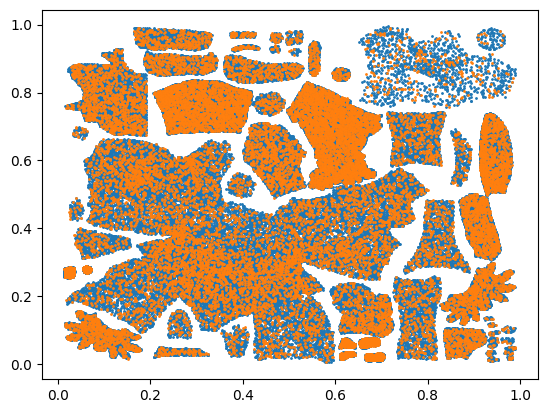

In [214]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:,0], X_train[:,1], s=1)
plt.scatter(X_test[:,0], X_test[:,1], s=1)
plt.show()

### Encoding

### Build Model

<b>Inputs:</b> u, v, thetas
<br/><b>Output</b>: occlusion factor

In [215]:
# positional encoding
def positional_encoding(pos, L):
    result = []
    for i in range(L//2):
        result.append(tf.sin(2**i * pos))
        result.append(tf.cos(2**i * pos))
    return tf.concat(result, axis=-1)


In [249]:
import keras.layers

# hidden layers
num_layers = 8
embed_dim = 10

# functional api model
input_func = keras.Input(shape=(2,), name="DAO")
embedding = positional_encoding(input_func, embed_dim//2)
hidden_layers = keras.Sequential([keras.layers.Dense(256, activation='relu') for _ in range(num_layers)])
x = hidden_layers(input_func)
output_func = keras.layers.Dense(1, activation='relu')(x)

# create model
model = keras.Model(input_func, output_func)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.MeanSquaredError())

<b>Inputs:</b> thetas
<br/><b>Output</b>: occlusion factor for all vertices

In [221]:
# # build model
# model = keras.Sequential([
#     keras.layers.Dense(256, input_shape=(x_len,), activation='relu'), # hidden
#     keras.layers.Dense(256, activation='relu'), # hidden
#     keras.layers.Dense(256, activation='relu'), # hidden
#     keras.layers.Dense(vertices, activation='relu') # output
# ])
# model.compile(optimizer="adam", loss=keras.losses.MeanSquaredError(), metrics="mse")

### Set up Tensorboard

In [251]:
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Train Model

In [250]:
# train model
log_dir = "logs/uv/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=X_train, 
          y=y_train, 
          epochs=100,
        #   batch_size=256,
          validation_data=(X_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/100


2661/2661 [==============================] - 25s 9ms/step - loss: 0.0232 - val_loss: 0.0236
Epoch 2/100
2661/2661 [==============================] - 25s 9ms/step - loss: 0.0227 - val_loss: 0.0232
Epoch 3/100
2661/2661 [==============================] - 27s 10ms/step - loss: 0.0222 - val_loss: 0.0230
Epoch 4/100
2661/2661 [==============================] - 25s 9ms/step - loss: 0.0218 - val_loss: 0.0224
Epoch 5/100
2661/2661 [==============================] - 23s 9ms/step - loss: 0.0215 - val_loss: 0.0220
Epoch 6/100
2661/2661 [==============================] - 24s 9ms/step - loss: 0.0214 - val_loss: 0.0220
Epoch 7/100
2661/2661 [==============================] - 25s 9ms/step - loss: 0.0212 - val_loss: 0.0221
Epoch 8/100
2661/2661 [==============================] - 24s 9ms/step - loss: 0.0211 - val_loss: 0.0217
Epoch 9/100
2661/2661 [==============================] - 24s 9ms/step - loss: 0.0210 - val_loss: 0.0218
Epoch 10/100
2661/2661 [==============================] - 24s 9ms/step - lo

In [252]:
%tensorboard --logdir logs/uv

### UV Data

### Test Accuracy

In [36]:
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)

2/2 [==============================] - 0s 6ms/step - loss: 0.0280 - mse: 0.0280
test loss, test acc: [0.028007308021187782, 0.028007308021187782]


### Get Model

In [37]:
wab = model.get_weights()

In [38]:
# manual evaluation 2 hidden layers: input = [u, v, theta]
# def manual_eval(input):
#     w1 = wab[0]
#     b1 = wab[1]
#     w2 = wab[2]
#     b2 = wab[3]
#     w3 = wab[4]
#     b3 = wab[5]

#     z1 = keras.activations.tanh(np.matmul(np.array(input), w1) + b1)
#     z2 = keras.activations.tanh(np.matmul(z1, w2) + b2)
#     z3 = keras.activations.tanh(np.matmul(z2, w3) + b3)
#     return z3.numpy()[0]

### Save to output file

In [39]:
# save weights and biases as buffer
output_buf = str(len(model.layers)) + "\n" # layer count

for i in range(0, len(wab)-1, 2): # iterate through layers
    weights = wab[i]
    output_buf += str(weights.shape[0]) + " " + str(weights.shape[1]) + "\n" # input size output size
    for neuron in weights: # iterate through
        for edges in neuron:
            output_buf += str(edges) + " "
    for biases in wab[i+1]:
        output_buf += str(biases) + " "
    output_buf = output_buf[:-1] + "\n" # ignore extraneous space and end line
    

In [40]:
with open("../resources/evaluators/model.txt", "w") as text_file:
    text_file.write(output_buf) # add more digits